In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tcs-stock-price/TCS.NS.csv


# **TIME SERIES PREDICTION OF TCS STOCK**

**1.SETTING UP THE DATA**

Importing the data and Libraries

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl 
from scipy import stats
import statsmodels.api as sm
import warnings
from statsmodels.tsa.stattools import adfuller
from itertools import product
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Load data
df = pd.read_csv('/kaggle/input/tcs-stock-price/TCS.NS.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-08-12,38.724998,40.000000,38.724998,39.700001,29.519140,212976.0
1,2002-08-13,39.750000,40.387501,38.875000,39.162498,29.119476,153576.0
2,2002-08-14,39.250000,39.250000,35.724998,36.462502,27.111877,822776.0
3,2002-08-15,36.462502,36.462502,36.462502,36.462502,27.111877,0.0
4,2002-08-16,36.275002,38.000000,35.750000,36.375000,27.046812,811856.0


In [4]:
#check datatype
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [5]:
#convert Date from Object to Date
df['Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
dtype: object

In [6]:
#Let's look at the data
df.index = df.Date
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2002-08-12,2002-08-12,38.724998,40.000000,38.724998,39.700001,29.519140,212976.0
2002-08-13,2002-08-13,39.750000,40.387501,38.875000,39.162498,29.119476,153576.0
2002-08-14,2002-08-14,39.250000,39.250000,35.724998,36.462502,27.111877,822776.0
2002-08-15,2002-08-15,36.462502,36.462502,36.462502,36.462502,27.111877,0.0
2002-08-16,2002-08-16,36.275002,38.000000,35.750000,36.375000,27.046812,811856.0


**2.ANALYSING THE DATA**

Determining which column better represent Stock price

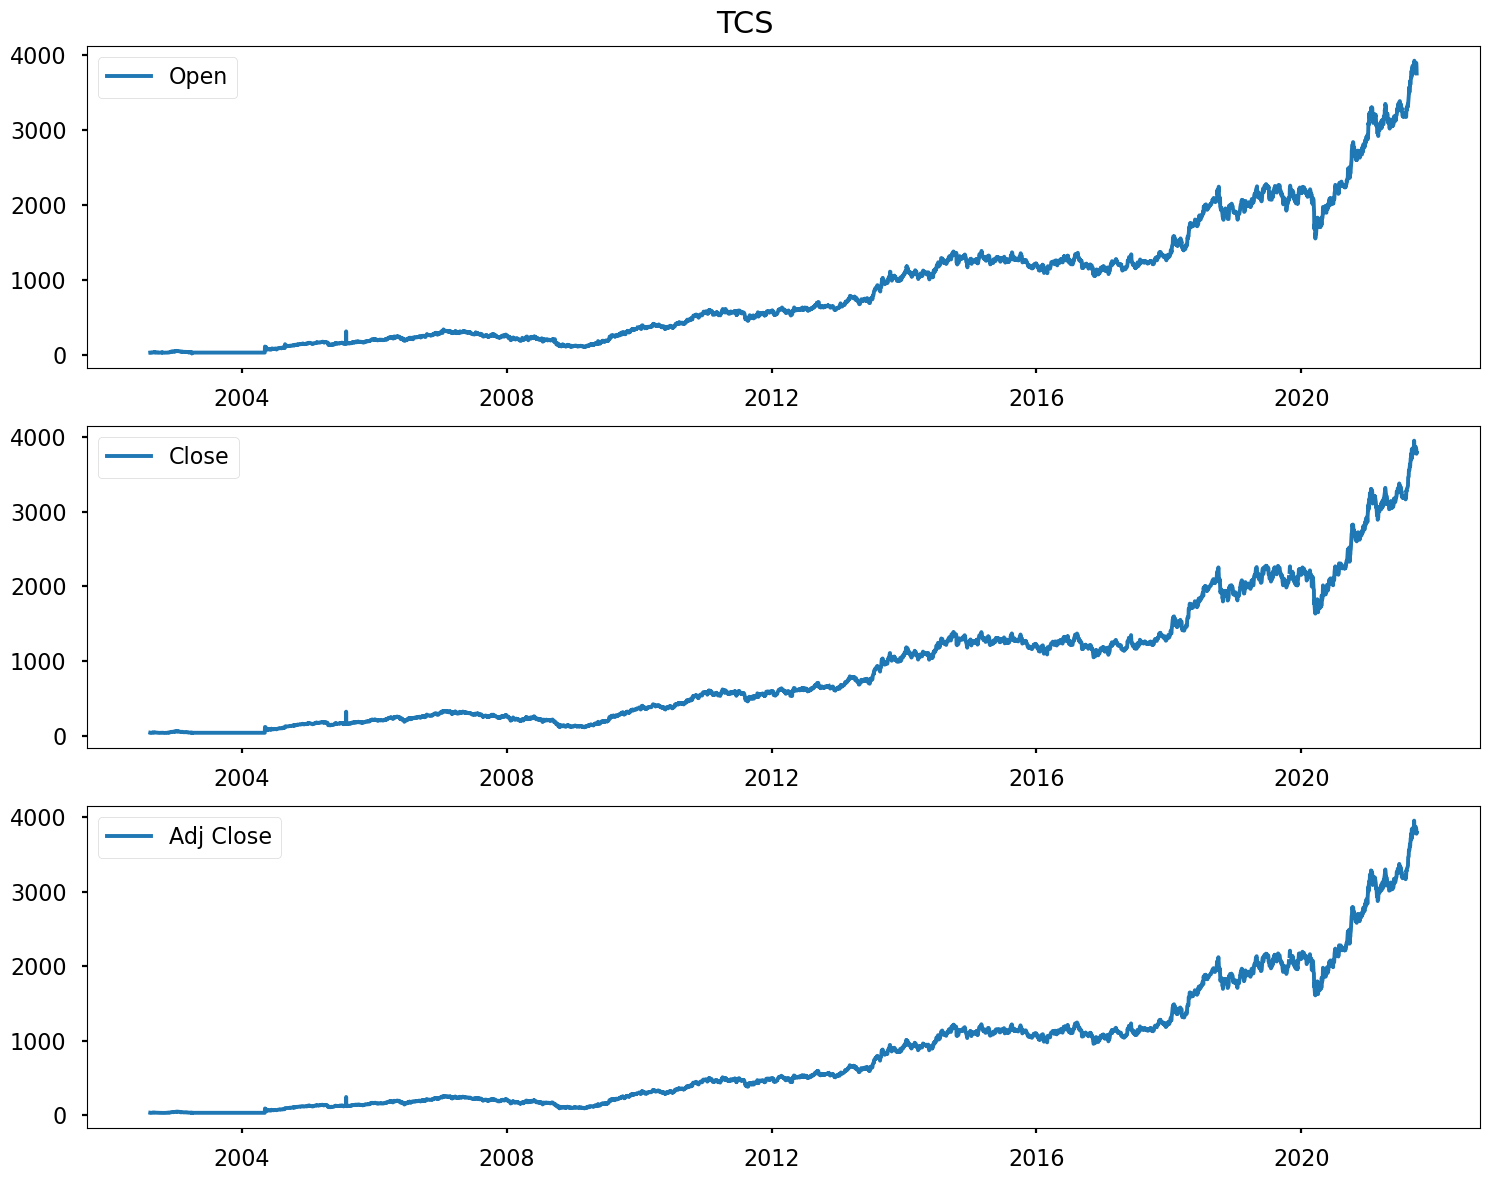

In [7]:
fig = plt.figure(figsize=[15, 12])
plt.suptitle('TCS', fontsize=22)

plt.subplot(311)
plt.plot(df.Open, '-', label='Open')
plt.legend()

plt.subplot(312)
plt.plot(df.Close, '-', label='Close')
plt.legend()

plt.subplot(313)
plt.plot(df['Adj Close'], '-', label='Adj Close')
plt.legend()
plt.tight_layout()
plt.show()

We will use Close Price for the rest since all the three data show similar pattern

In [8]:
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

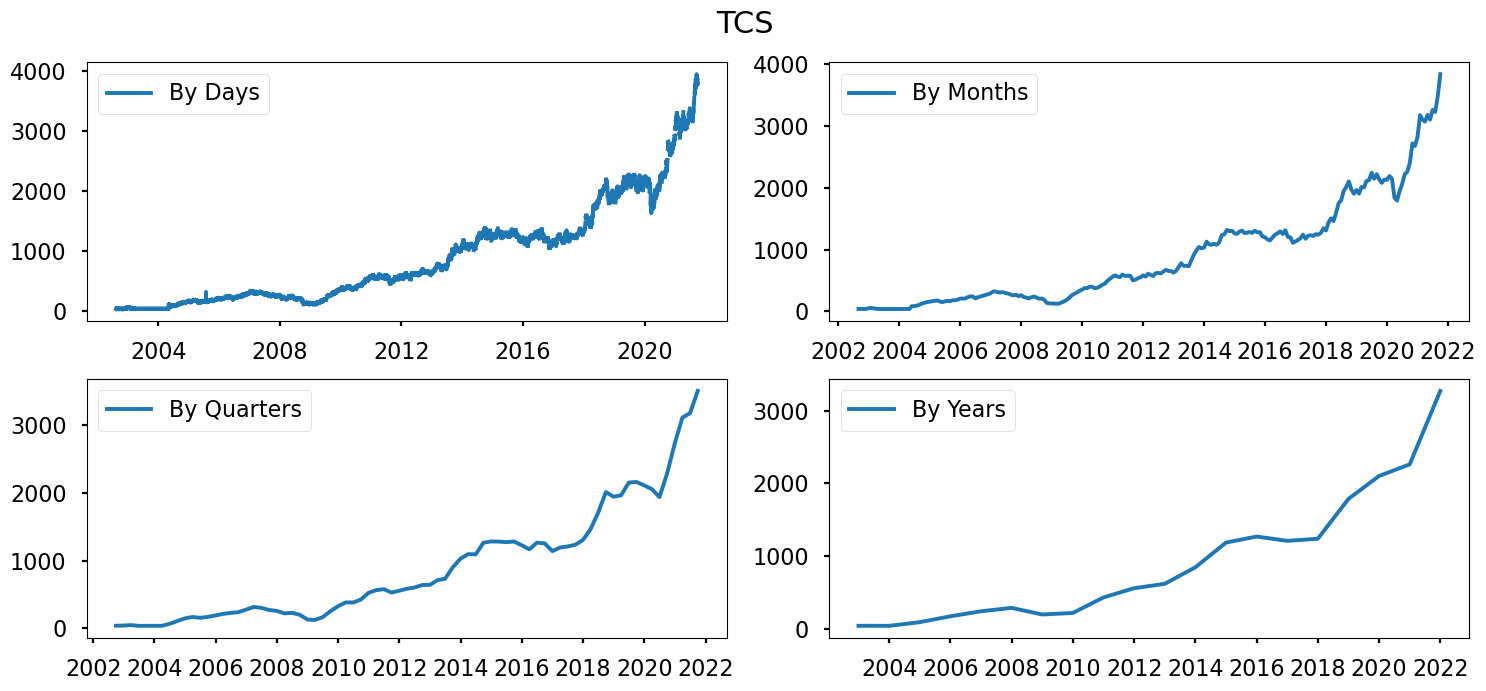

In [9]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('TCS', fontsize=22)

plt.subplot(221)
plt.plot(df.Close, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Close, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Close, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Close, '-', label='By Years')
plt.legend()

plt.tight_layout()
plt.show()

We will predict TCS Stock price by months

In [10]:
#dropping rest columns
df_month.drop('Open',1,inplace=True)
df_month.drop('High',1,inplace=True)
df_month.drop('Low',1,inplace=True)
df_month.drop('Adj Close',1,inplace=True)
df_month.drop('Volume',1,inplace=True)


In [11]:
df_month.rename(columns = {'Close':'Price'}, inplace = True)
df_month

,Price
Date,
2002-08-31,39.341667
2002-09-30,40.422619
2002-10-31,37.527174
2002-11-30,39.098215
2002-12-31,51.927841
...,...
2021-05-31,3102.590002
2021-06-30,3258.345470
2021-07-31,3225.997640


In [12]:
df_month1=df_month

**3.STATIONARY CHECK & TRANSFORMATION**

<Figure size 1500x700 with 0 Axes>

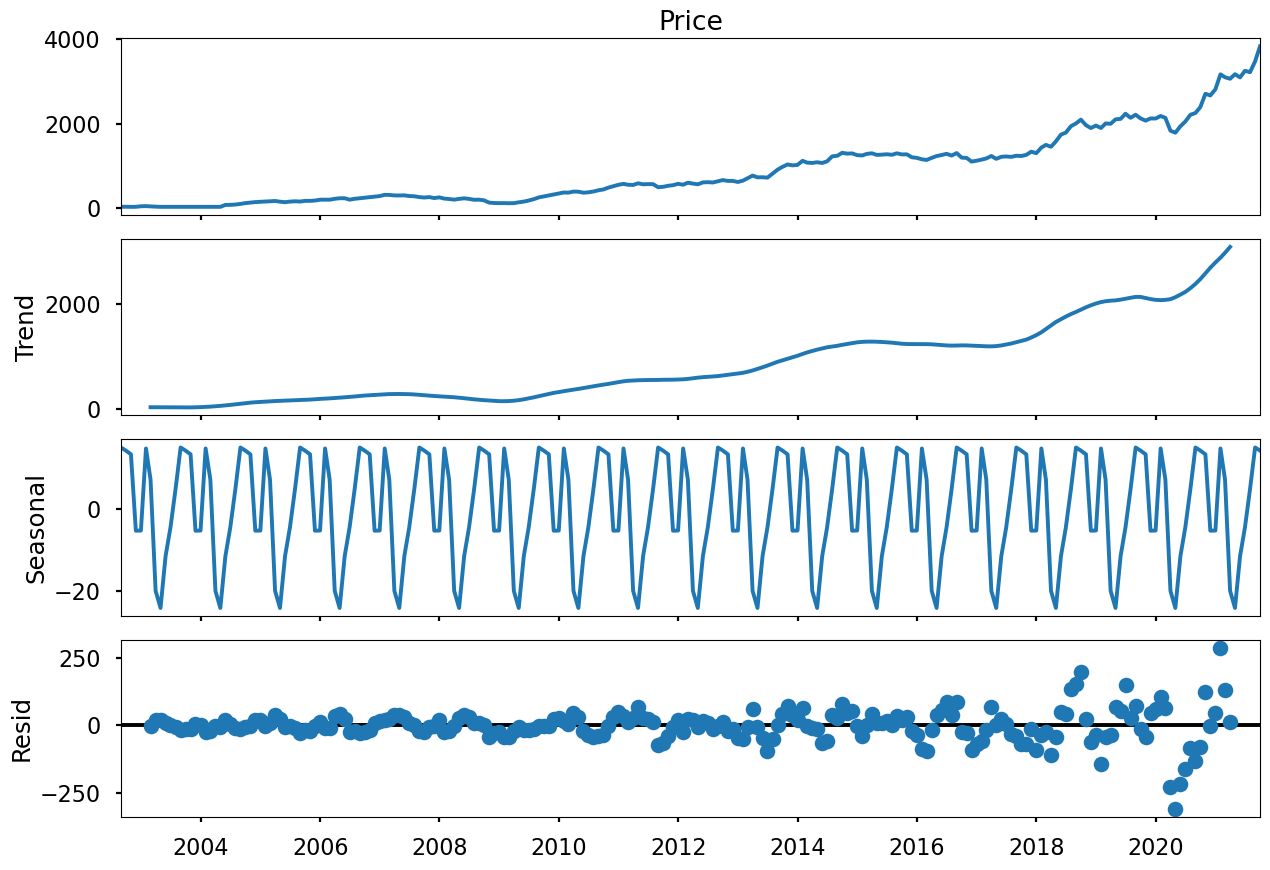

In [13]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Price).plot()
plt.show()

Data has both Trend and Seasonality and is not Stationary

In [14]:
result = sm.tsa.stattools.adfuller(df_month.Price)
def adfuller_test(Price):
    result=adfuller(Price)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

if result[1] <= 0.05:
    print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
    print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(df_month['Price'])

weak evidence against null hypothesis,indicating it is non-stationary 
ADF Test Statistic : 2.362229028385937
p-value : 0.998991411149752
#Lags Used : 11
Number of Observations : 218


In [15]:
# Box-Cox Transformations
df_month['Price_box'], lmbda = stats.boxcox(df_month.Price)

In [16]:
print("ADF test: p=%f" % adfuller(df_month.Price)[1])

ADF test: p=0.998991


In [17]:
# Seasonal differentiation
df_month['Price_box_diff'] = df_month.Price_box - df_month.Price_box.shift(12)
print("ADF test: p=%f" % adfuller(df_month.Price_box_diff[12:])[1])

ADF test: p=0.004566


In [18]:
result = sm.tsa.stattools.adfuller(df_month.Price_box_diff[12:])
def adfuller_test(Price):
    result=adfuller(Price)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

if result[1] <= 0.05:
    print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
    print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(df_month.Price_box_diff[12:])

strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary
ADF Test Statistic : -3.669323874339312
p-value : 0.00456592596822557
#Lags Used : 14
Number of Observations : 203


Data is stationary

**4.ARIMA MODEL**

In [19]:
#dropping null values and keeping original for inversing values
df_month1 = df_month[13:]

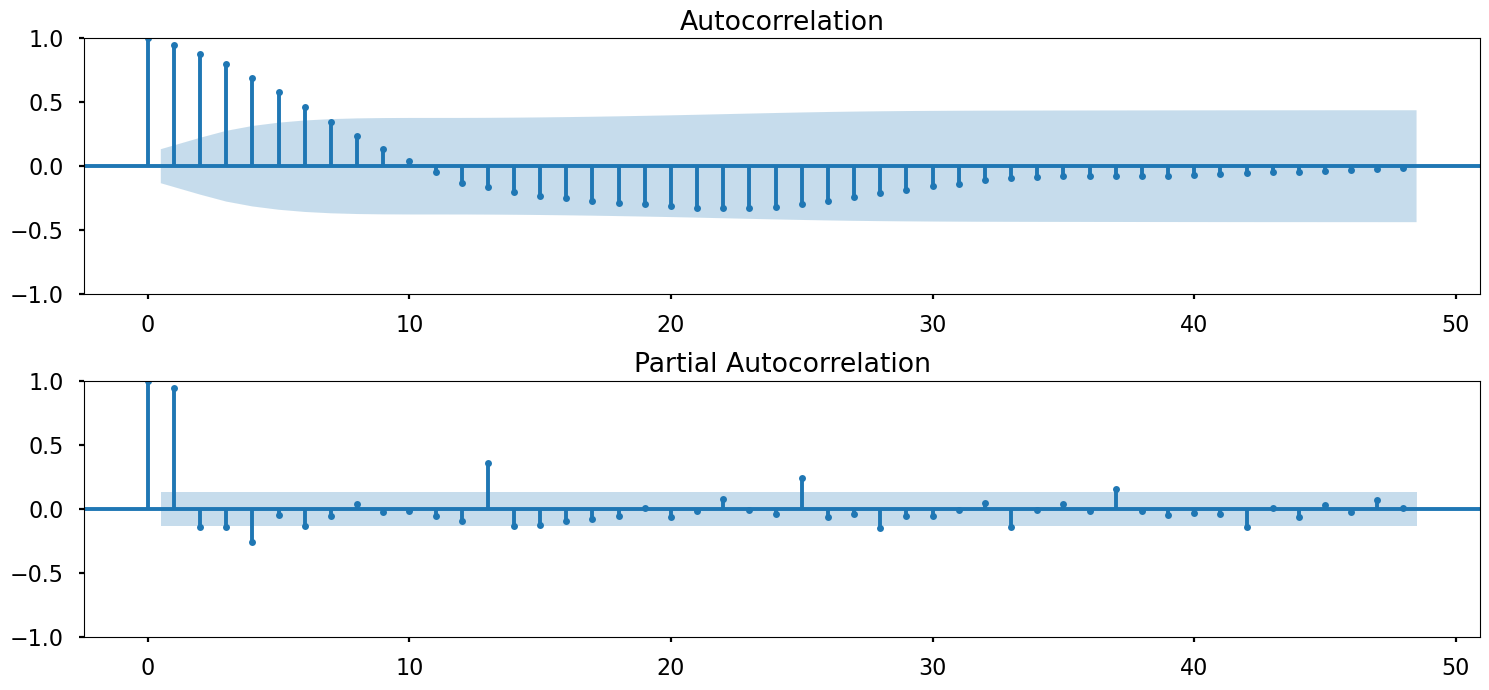

In [20]:
#Parameters using ACF and PACF
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month1.Price_box_diff.values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month1.Price_box_diff.values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [21]:
#iteration tool to find p,d,q values
import itertools
p=d=q=range(0,5)
pdq =list(itertools.product(p,d,q))

In [22]:
#Find AIC values for all p,d,q values
AIC={}
for i in pdq:
  try:
    model_arima=ARIMA(df_month1['Price_box_diff'],order=(i))
    model_fit=model_arima.fit()
    print(model_fit.aic," ",i)
    AIC[model_fit.aic]=i
  except:
      continue

739.5382697736161   (0, 0, 0)
511.95112663215633   (0, 0, 1)
414.7103308083308   (0, 0, 2)
328.48998227070217   (0, 0, 3)
288.65246791422743   (0, 0, 4)
233.63017784471722   (0, 1, 0)
231.89864024659144   (0, 1, 1)
231.62653590504272   (0, 1, 2)
226.45676591048445   (0, 1, 3)
228.30458945925875   (0, 1, 4)
348.62409754239627   (0, 2, 0)
242.07859375424192   (0, 2, 1)
238.78077075461664   (0, 2, 2)
238.39169180050752   (0, 2, 3)
233.0216342865457   (0, 2, 4)
582.9107531381874   (0, 3, 0)
355.38247254250285   (0, 3, 1)
252.87521429509292   (0, 3, 2)
254.75843545800404   (0, 3, 3)
253.45312469497253   (0, 3, 4)
835.9669981495501   (0, 4, 0)
588.5613976517152   (0, 4, 1)
419.4760180134663   (0, 4, 2)
270.4404499024862   (0, 4, 3)
272.50290718654406   (0, 4, 4)
236.0385835047258   (1, 0, 0)
233.0071628485723   (1, 0, 1)
231.92224487814883   (1, 0, 2)
224.86461619129727   (1, 0, 3)
226.01733589264546   (1, 0, 4)
231.06851023343776   (1, 1, 0)
227.39582819740593   (1, 1, 1)
228.03130786683218

In [23]:
AIC[min(AIC.keys())]

(4, 0, 4)

In [24]:
model_arima=ARIMA(df_month1['Price_box_diff'],order=(4,0,4))
model_fit=model_arima.fit()

In [25]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Price_box_diff   No. Observations:                  217
Model:                 ARIMA(4, 0, 4)   Log Likelihood                 -91.808
Date:                Fri, 25 Aug 2023   AIC                            203.615
Time:                        10:45:14   BIC                            237.414
Sample:                    09-30-2003   HQIC                           217.269
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8590      0.051     16.890      0.000       0.759       0.959
ar.L1          0.5765      0.025     22.892      0.000       0.527       0.626
ar.L2          0.7126      0.027     26.373      0.000       0.660       0.766
ar.L3          0.6184      0.024     25.512      0.000       0.571       0.666
ar.L4         -0.9513      0.025    -37.705      0.000      -1.001      -0.902
ma.L1          0.4924      0.123      3.987      0.000       0.250       0.734
ma.L2         -0.3354      0.169     -1.980      0.048      -0.667      -0.003
ma.L3         -1.0062      0.155     -6.478      0.000      -1.311      -0.702
ma.L4         -0.1392      0.093     -1.493      0.136      -0.322       0.044
sigma2         0.1321      0.018      7.372      0.000       0.097       0.167
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):               191.69
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                            -0.27
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

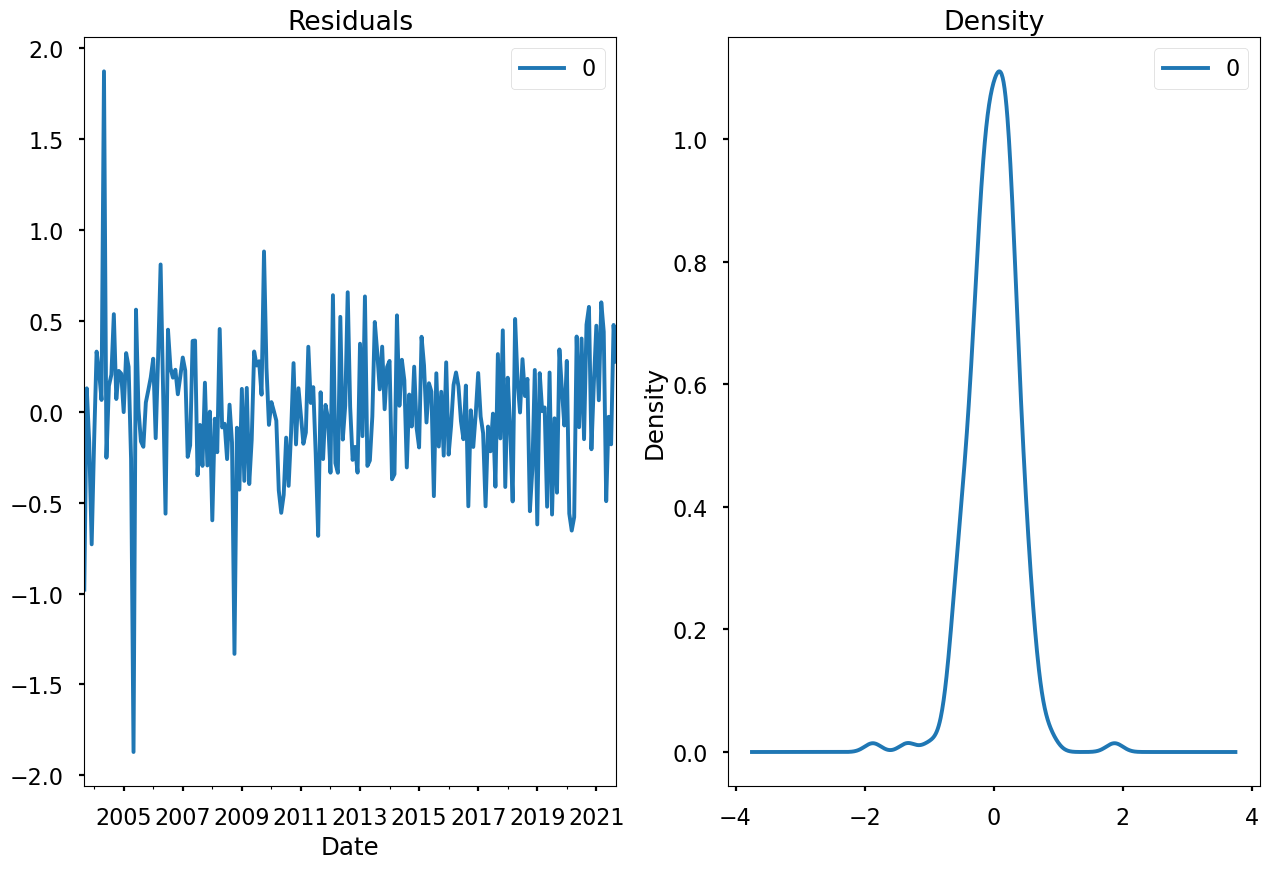

In [26]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.tight_layout()
plt.show()

**5.MODEL PREDICTION**

In [27]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [28]:
# Prediction & reveresing difference and boxcox
df_month3 = pd.DataFrame()
df_month2 = df_month[['Price']]
date_list = [datetime(2017, 6, 30), datetime(2017, 7, 31), datetime(2017, 8, 31), datetime(2017, 9, 30), 
             datetime(2017, 10, 31), datetime(2017, 11, 30), datetime(2017, 12, 31), datetime(2018, 1, 31),
             datetime(2018, 1, 28)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = model_fit.predict(start=0, end=217)
df_month3['forecast'] = df_month2['forecast'] + df_month.Price_box.shift(12)
df_month3['forecast'] = invboxcox(df_month3['forecast'], lmbda)

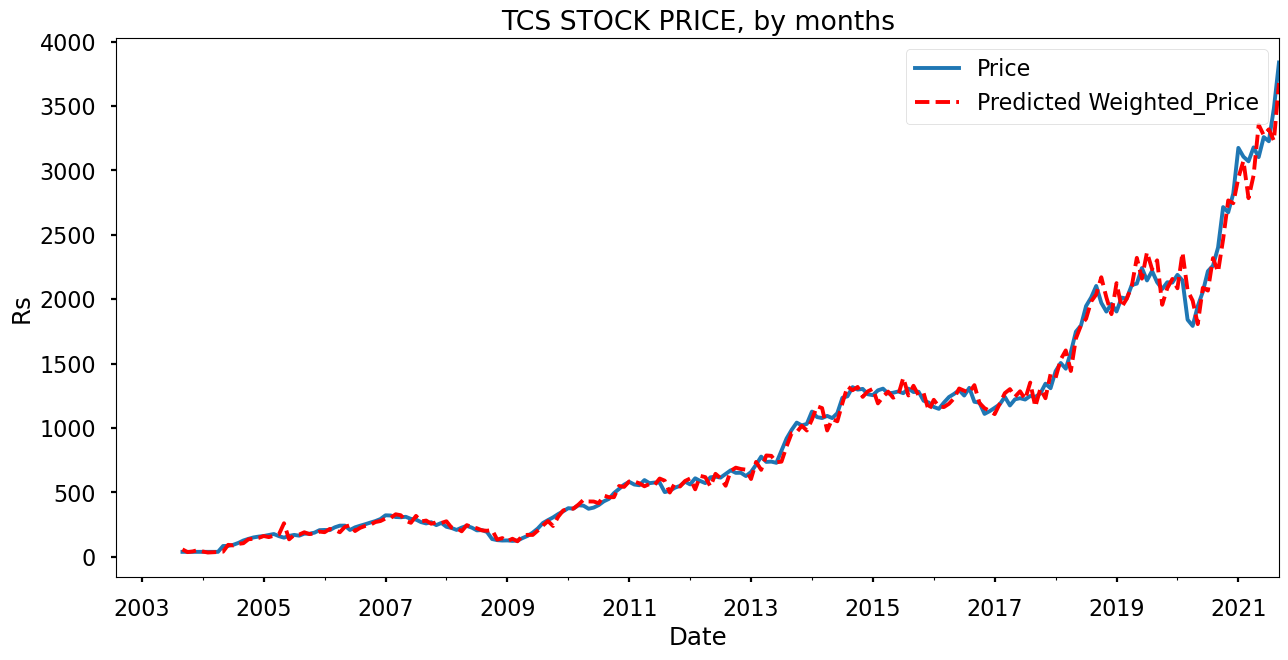

In [29]:
#plt comparing Original and Predicted
plt.figure(figsize=(15,7))
df_month1.Price.plot()
df_month3.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('TCS STOCK PRICE, by months')
plt.ylabel('Rs')
plt.show()

**6.TESTING MODEL USING VALIDATION SPLIT**

In [30]:
#Splitting into Train and test
X = df_month1['Price_box_diff'].values
size = int(len(X) * 0.88)
train, test= X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [31]:
#Splitting the index
train_date=df_month1['Price_box_diff'].index[0:size]
test_date=df_month1['Price_box_diff'].index[size:len(X)]

In [32]:
#using the same AIC fitting only train
model_arima=ARIMA(train,order=(4,0,4))
model_fit=model_arima.fit()

In [33]:
predictions=[]
# walk-forward validation
for t in range(len(test)):
  model = ARIMA(history, order=(4,0,4))
  model.initialize_approximate_diffuse()
  model_fit = model.fit()
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  obs = test[t]
  history.append(obs)
  print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecast

predicted=1.249423, expected=0.552700
predicted=0.614136, expected=0.557966
predicted=0.269572, expected=0.077673
predicted=0.134674, expected=0.300325
predicted=0.118818, expected=0.640116
predicted=0.723089, expected=0.461118
predicted=0.454580, expected=0.791002
predicted=0.938579, expected=0.364894
predicted=0.437346, expected=-0.477357
predicted=-0.563704, expected=-0.914572
predicted=-0.779513, expected=-0.489077
predicted=-0.711504, expected=-0.492231
predicted=-0.365044, expected=0.189658
predicted=0.238703, expected=0.105319
predicted=0.340725, expected=0.693098
predicted=1.077965, expected=1.569623
predicted=1.723133, expected=1.336650
predicted=1.461131, expected=1.665212
predicted=2.020983, expected=2.238812
predicted=2.158447, expected=2.218397
predicted=2.338746, expected=3.010642
predicted=3.158126, expected=3.373532
predicted=3.243769, expected=2.766409
predicted=2.935888, expected=2.757501
predicted=2.545934, expected=2.266029
predicted=2.046467, expected=2.641659
pred

Test RMSE: 0.415


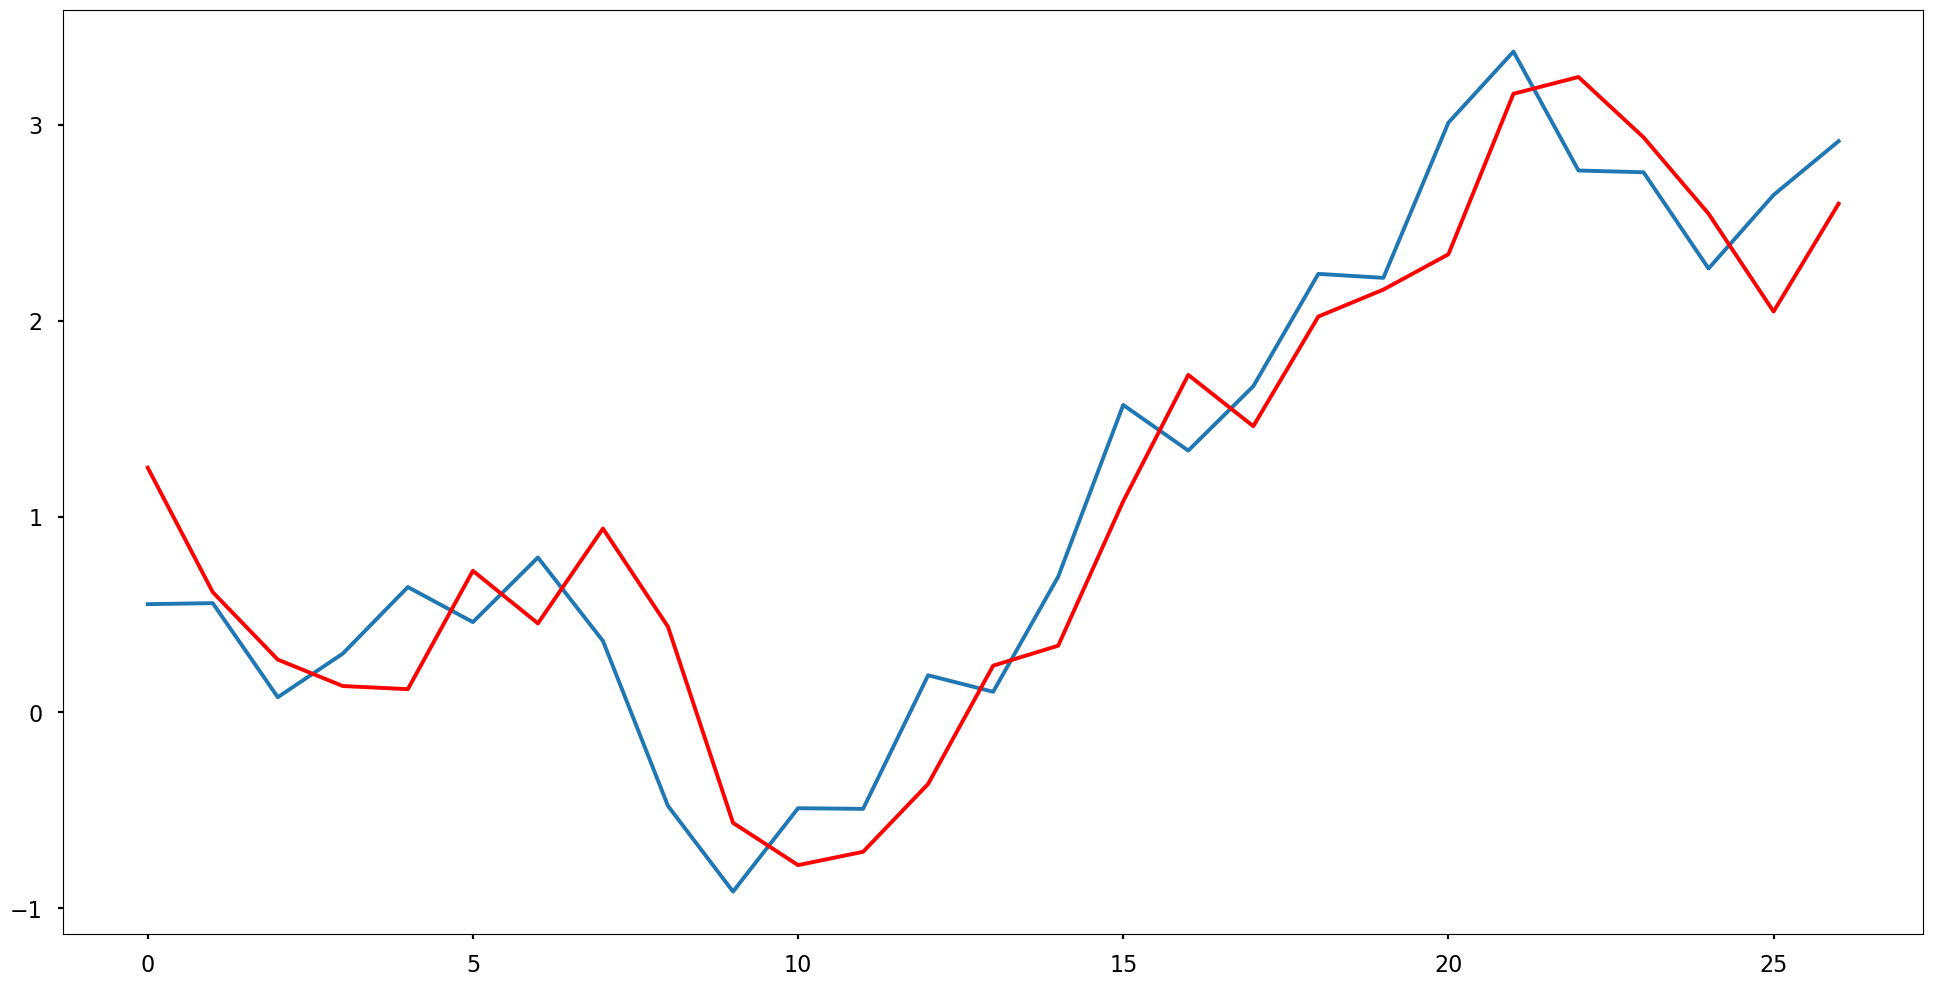

In [34]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.figure(figsize=(24,12))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()


In [35]:
from sklearn.metrics import mean_absolute_error
print('Mean Absolute Error:',mean_absolute_error(test.reshape(-1),predictions))

Mean Absolute Error: 0.35988745453273063


> FOR BETTER AND REAL TIME USAGE OF STOCK PRICE PREDICTION WE NEED TO INPUT FURTHER COLUMNS INTO THE MODEL